# test model on test data 
Test the model on the test data and save the results.


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import os 
os.environ['MPLCONFIGDIR'] = '/myhome'
from datetime import datetime
sys.path.append("..")
from data import BavarianCrops, BreizhCrops, SustainbenchCrops, ModisCDL
from models.earlyrnn import EarlyRNN
from models.daily_earlyrnn import DailyEarlyRNN
import torch
from utils.losses.early_reward_loss import EarlyRewardLoss
from utils.losses.stopping_time_proximity_loss import StoppingTimeProximityLoss, sample_three_uniform_numbers
from utils.losses.daily_reward_loss import DailyRewardLoss
import pandas as pd
import pickle 
import wandb
import json
from utils.plots import plot_label_distribution_datasets, boxplot_stopping_times, plot_timestamps_left_per_class
from utils.doy import get_doys_dict_test, get_doy_stop
from utils.helpers_training import parse_args
from utils.helpers_config import set_up_config
from utils.helpers_testing import test_dataset, get_test_stats, get_test_stats_from_model
import matplotlib.pyplot as plt
from utils.plots_test import plot_doy_prob, plot_all_doy_probs, plot_confusion_matrix, plot_probability_stopping, \
    plot_fig_class_prob_wrt_time, plot_fig_class_prob_wrt_time_one_sample, plot_fig_class_prob_wrt_time_with_mus
from models.model_helpers import count_parameters
from utils.extract_mu import extract_mu_thresh
from utils.test.load_model import get_all_runs, get_best_run, download_model, get_loaded_model_and_criterion, \
    get_model_and_model_path
import argparse

In [3]:
local_dataroot = os.path.join(os.environ.get("HOME", os.environ.get("USERPROFILE")),"elects_data")
print("Local dataroot: ", local_dataroot)

Local dataroot:  C:\Users\anyam\elects_data


## Download the model from wandb 

In [4]:
entity, project, sweep = "aurenore", "MasterThesis", "piecewise_lin_regr"
runs_df, runs = get_all_runs(entity, project)
df = runs_df[runs_df.sweep == sweep]

In [5]:
print(f"Number of runs in sweep {sweep}: ", len(df))
df.head()

Number of runs in sweep piecewise_lin_regr:  104


,summary,config,name,sweep,start_date
20,{'class_probabilities_wrt_time': {'width': 150...,"{'mu': 150, 'loss': 'daily_reward_lin_regr', '...",chocolate-sweep-104,piecewise_lin_regr,2024-06-11T12:38:32
21,"{'_step': 100, 'boxplot': {'width': 1500, 'for...","{'mu': 150, 'loss': 'daily_reward_lin_regr', '...",lively-sweep-103,piecewise_lin_regr,2024-06-11T12:34:54
22,"{'fscore': 0.5510330210020846, 'harmonic_mean'...","{'mu': 150, 'loss': 'daily_reward_lin_regr', '...",fanciful-sweep-102,piecewise_lin_regr,2024-06-11T12:32:27
23,"{'loss': {'testloss': 4.671197891235352, 'trai...","{'mu': 150, 'loss': 'daily_reward_lin_regr', '...",breezy-sweep-101,piecewise_lin_regr,2024-06-11T12:27:42
30,"{'kappa': 0.5962082082396665, 'recall': 0.6500...","{'mu': 150, 'loss': 'daily_reward_lin_regr', '...",gentle-sweep-100,piecewise_lin_regr,2024-06-11T11:39:45


get the best run according to a metric 

In [6]:
metric = "harmonic_mean"
run = get_best_run(df, runs, metric)
print("configurations of the best run:")
print("-"*50)
for key, value in run.config.items():
    print(f"{key}: {value}")
print("-"*50)

chosen run:  earthy-sweep-92
with harmonic_mean:  0.6680139471090303
configurations of the best run:
--------------------------------------------------
mu: 150
loss: daily_reward_lin_regr
alpha: 1
device: cuda
epochs: 100
resume: False
dataset: breizhcrops
epsilon: 10
dataroot: /home/amauron/elects/data/elects_data
p_thresh: 0.7
patience: 30
snapshot: /home/amauron/elects/data/elects_snapshots/model.pth
batchsize: 256
corrected: True
alpha_decay: [1, 0.6]
hidden_dims: 64
loss_weight: balanced
left_padding: False
weight_decay: 0
backbonemodel: LSTM
class_weights: [0.04731182754039765, 0.02670983411371708, 0.14316703379154205, 0.01290007308125496, 1, 0.011567785404622557, 0.010797104798257353]
decision_head: day
learning_rate: 0.001
nb_parameters: 66978
sequencelength: 365
validation_set: valid
daily_timestamps: True
day_head_init_bias: 5
extra_padding_list: [0]
original_time_serie_lengths: [102]
percentage_earliness_reward: 0.6
start_decision_head_training: 2
---------------------------

or get the model from the run name: 

In [7]:
run_name = "sage-spaceship-4630"
run_idx = runs_df[runs_df.name == run_name].index[0]
run = runs[run_idx]
run_config = argparse.Namespace(**run.config)
model_artifact, model_path = get_model_and_model_path(run)

# save the config json file 
config_path = os.path.join(model_path, "config.json")
with open(config_path, "w") as f:
    json.dump(run.config, f)
print("config file saved at: ", config_path)
    
print("config:")
for key, value in run.config.items():
    print(f"{key}: {value}")

wandb:   1 of 1 files downloaded.  


config file saved at:  c:\Users\anyam\Desktop\Master_thesis\Code\elects\results_analysis_notebooks\artifacts\run-lygfmdv8-model.pth-v10\config.json
config:
loss: daily_reward_lin_regr
alpha: 1
device: cuda
epochs: 100
resume: False
dataset: breizhcrops
epsilon: 10
dataroot: /home/amauron/elects/data/elects_data
p_thresh: 0.7
patience: 30
snapshot: /home/amauron/elects/data/elects_snapshots/model.pth
batchsize: 256
corrected: False
criterion: daily_reward_lin_regr
optimizer: AdamW
alpha_decay: [1, 0.6]
hidden_dims: 64
loss_weight: balanced
architecture: EarlyRNN
left_padding: False
weight_decay: 0
backbonemodel: LSTM
class_weights: [0.0002943773870356381, 0.00015427677135448903, 0.000881723128259182, 8.686695946380496e-05, 1, 0.005409582518041134, 0.25, 0.00010121164814336224, 7.684454612899572e-05]
decision_head: day
learning_rate: 0.001
nb_parameters: 67108
sequencelength: 70
validation_set: valid
daily_timestamps: False
day_head_init_bias: 5
extra_padding_list: [0]
original_time_seri

## Test the model on the test set 
Set the sequence length to 150 like in the original paper. 

In [9]:
args, _ = set_up_config(run_config)
args.dataroot = local_dataroot

In [10]:
# ----------------------------- LOAD DATASET -----------------------------
sequencelength_test = 150 # by elects paper
if args.dataset == "breizhcrops":
    dataroot = os.path.join(args.dataroot,"breizhcrops")
    input_dim = 13
    doys_dict_test = get_doys_dict_test(dataroot=os.path.join(args.dataroot,args.dataset))
    test_ds = BreizhCrops(root=dataroot, partition="eval", sequencelength=sequencelength_test, corrected=args.corrected, \
        daily_timestamps=args.daily_timestamps, original_time_serie_lengths=args.original_time_serie_lengths, return_id=True)
    nclasses = test_ds.nclasses
    class_names = test_ds.labels_names
    print("class names:", class_names)
else:
    raise ValueError(f"dataset {args.dataset} not recognized")


1555075632 1555075632


loading data into RAM: 100%|██████████| 122614/122614 [00:43<00:00, 2804.16it/s]

class names: ['barley' 'wheat' 'rapeseed' 'corn' 'sunflower' 'orchards' 'nuts'
 'permanent meadows' 'temporary meadows']


In [11]:
# print all the attributes of test_ds
print("Attributes of test_ds:")
for attr in dir(test_ds):
    if not attr.startswith("__"):
        print(attr, ":", getattr(test_ds, attr))

Attributes of test_ds:
_is_protocol : False
class_weights : None
corrected : False
daily_timestamps : False
ds : <data.breizhcrops.BzhBreizhCrops object at 0x000001A45F7D7A90>
get_class_weights : <bound method BreizhCrops.get_class_weights of <data.breizhcrops.BreizhCrops object at 0x000001A463C48610>>
get_sequence_lengths : <bound method BreizhCrops.get_sequence_lengths of <data.breizhcrops.BreizhCrops object at 0x000001A463C48610>>
labels_names : ['barley' 'wheat' 'rapeseed' 'corn' 'sunflower' 'orchards' 'nuts'
 'permanent meadows' 'temporary meadows']
nclasses : 9
return_id : True
sequencelength : 150


Extracting labels from dataset Test.


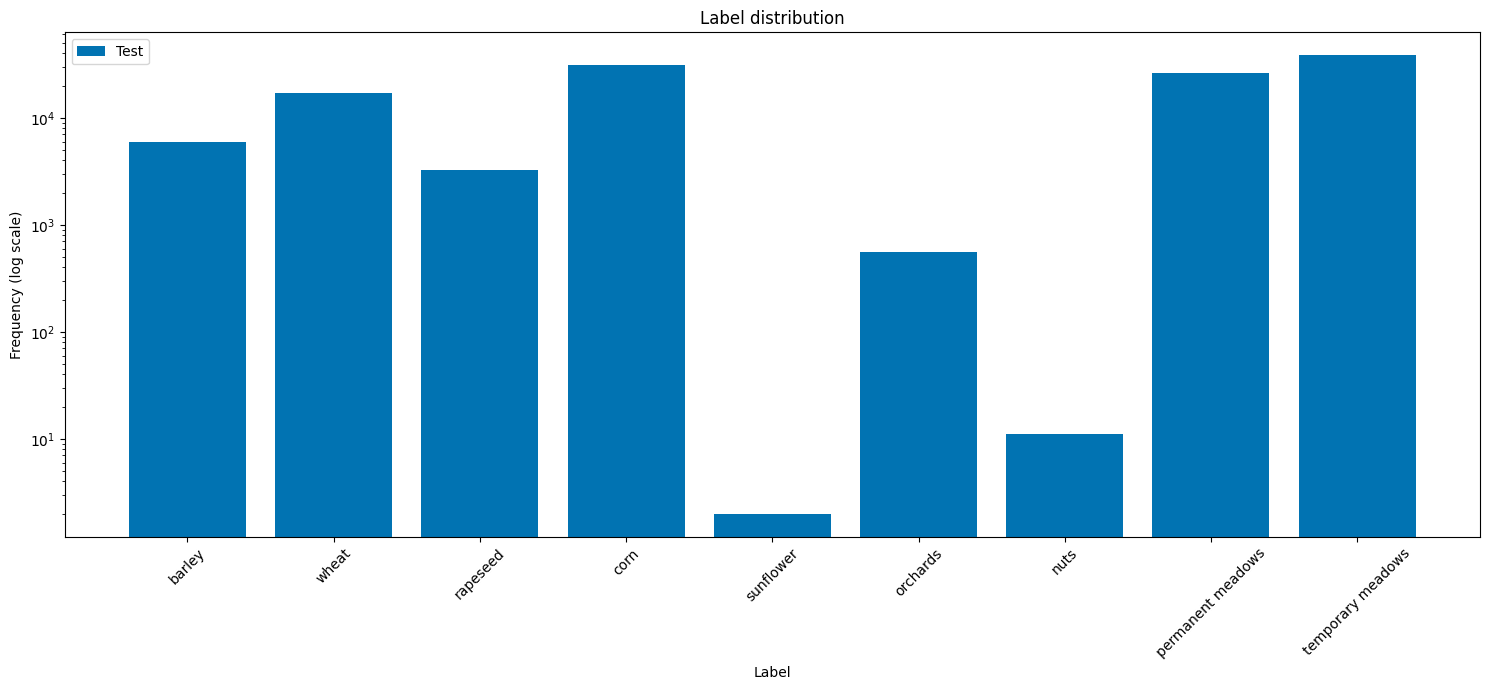

In [12]:
# take about 1 minute
# ----------------------------- VISUALIZATION: label distribution -----------------------------
datasets = [test_ds]
sets_labels = ["Test"]
fig, ax = plt.subplots(figsize=(15, 7))
fig, ax = plot_label_distribution_datasets(datasets, sets_labels, fig, ax, title='Label distribution', labels_names=class_names)

## Load the models and the criterions

In [18]:
# get the mus from the summary of the model
# print the keys of summary
for key in run.summary.keys():
    print(key)

_runtime
accuracy
_step
alpha
_wandb
recall
boxplot
timestamps_left_plot
epoch
alphas
fscore
earliness_reward
label_distribution
loss
_timestamp
harmonic_mean
elects_earliness
class_probabilities_wrt_time
kappa
precision
conf_mat_table
lin_regr_zt_loss
classification_loss


In [13]:
model, criterion = get_loaded_model_and_criterion(run, nclasses, input_dim)

wandb:   1 of 1 files downloaded.  
c:\Users\anyam\Desktop\Master_thesis\Code\elects\results_analysis_notebooks\..\utils\test\load_model.py:79: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  class_weights = torch.tensor(run_config.class_weights)


loss daily_reward_lin_regr selected, setting mus to 28
model is loading from:  c:\Users\anyam\Desktop\Master_thesis\Code\elects\results_analysis_notebooks\artifacts\run-lygfmdv8-model.pth-v10
The model has 67,108 trainable parameters.


## Test the model on the test dataset

In [14]:
test_stats, stats = get_test_stats_from_model(model, test_ds, criterion, run_config)

Since LSTM is used, extra padding is set to [0]
weights moved to device cuda


c:\Users\anyam\Desktop\Master_thesis\Code\elects\results_analysis_notebooks\..\utils\helpers_config.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  config.class_weights = torch.tensor(config.class_weights).to(config.device)


In [15]:
test_stats

{'test_loss': 0.31849927,
 'accuracy': 0.36235666400247935,
 'precision': 0.47042022236179715,
 'recall': 0.40454416622617057,
 'fscore': 0.36377803316977414,
 'kappa': 0.2883687263134611,
 'elects_earliness': 0.6666563834236012,
 'classification_loss': 0.047741465,
 'earliness_reward': 0.0054188194,
 'harmonic_mean': 0.4695127700034085}

## Graphs

fig saved at  c:\Users\anyam\Desktop\Master_thesis\Code\elects\results_analysis_notebooks\artifacts\run-dovekjsx-model.pth-v6\boxplot_stopping_times.png


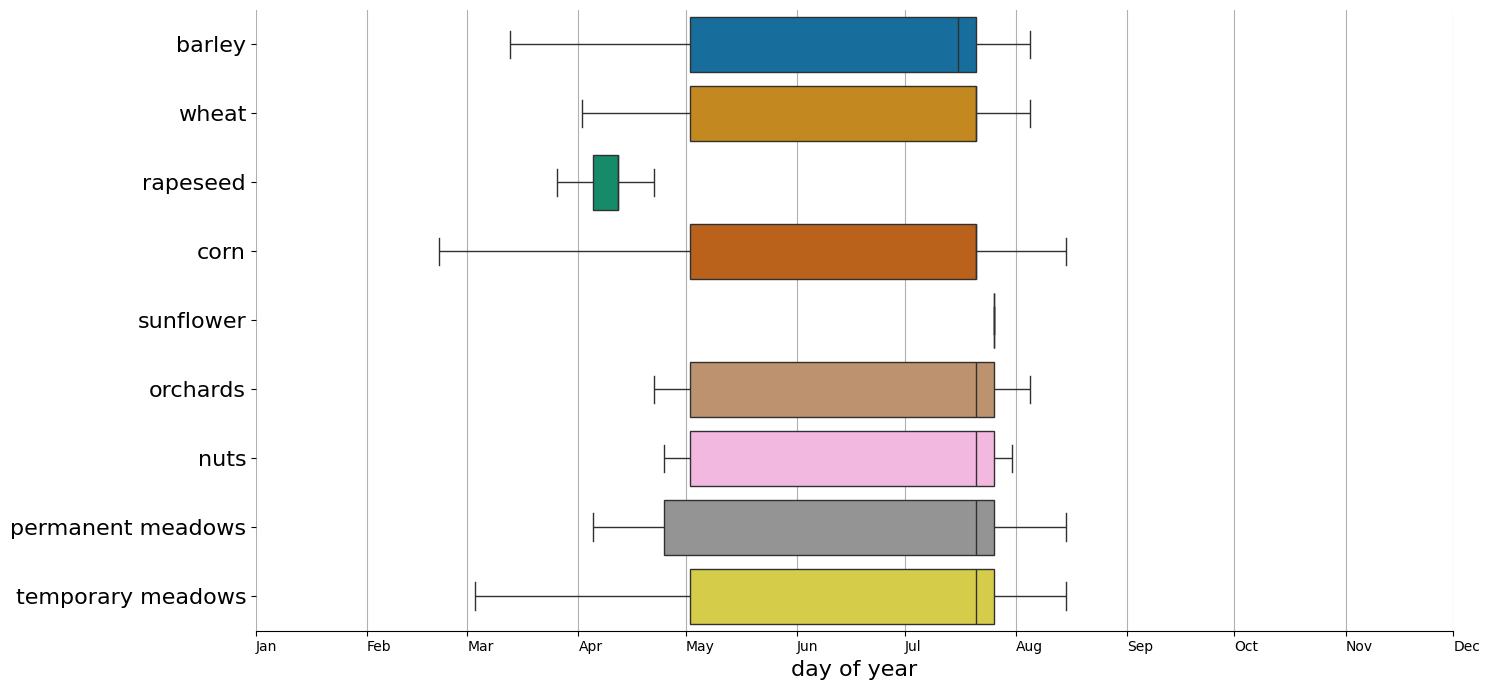

In [16]:
from utils.doy import get_doys_dict_test, get_doy_stop, create_sorted_doys_dict_test, get_approximated_doys_dict, get_approximated_doy
# ----------------------------- VISUALIZATION: stopping times -----------------------------
fig_boxplot, ax_boxplot = plt.subplots(figsize=(15, 7))
if args.daily_timestamps:
    doys_stop = stats["t_stop"].squeeze()
else: 
    doys_dict_test = get_doys_dict_test(dataroot=os.path.join(args.dataroot,args.dataset))
    doys_stop = get_doy_stop(stats, doys_dict_test, approximated=False)
fig_boxplot, _ = boxplot_stopping_times(doys_stop, stats, fig_boxplot, ax_boxplot, class_names)
                
fig_boxplot.savefig(os.path.join(model_path, "boxplot_stopping_times.png"))
print("fig saved at ", os.path.join(model_path, "boxplot_stopping_times.png"))

fig saved at  c:\Users\anyam\Desktop\Master_thesis\Code\elects\results_analysis_notebooks\artifacts\run-dovekjsx-model.pth-v6\confusion_matrix.png


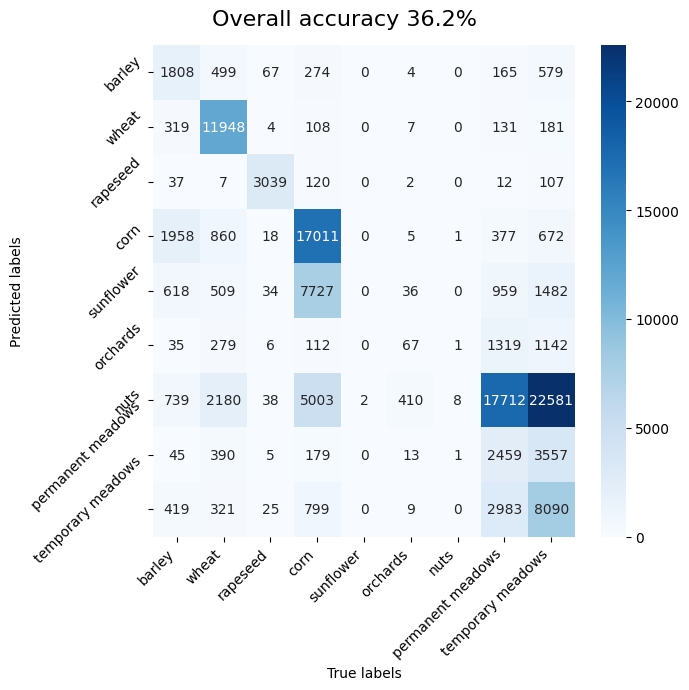

In [17]:
fig, ax = plt.subplots(figsize=(7,7))
fig = plot_confusion_matrix(stats["targets"][:, 0], stats["predictions_at_t_stop"].flatten(), class_names, fig, ax)
fig.savefig(os.path.join(model_path, "confusion_matrix.png"))
print("fig saved at ", os.path.join(model_path, "confusion_matrix.png"))

NameError: name 'mus' is not defined

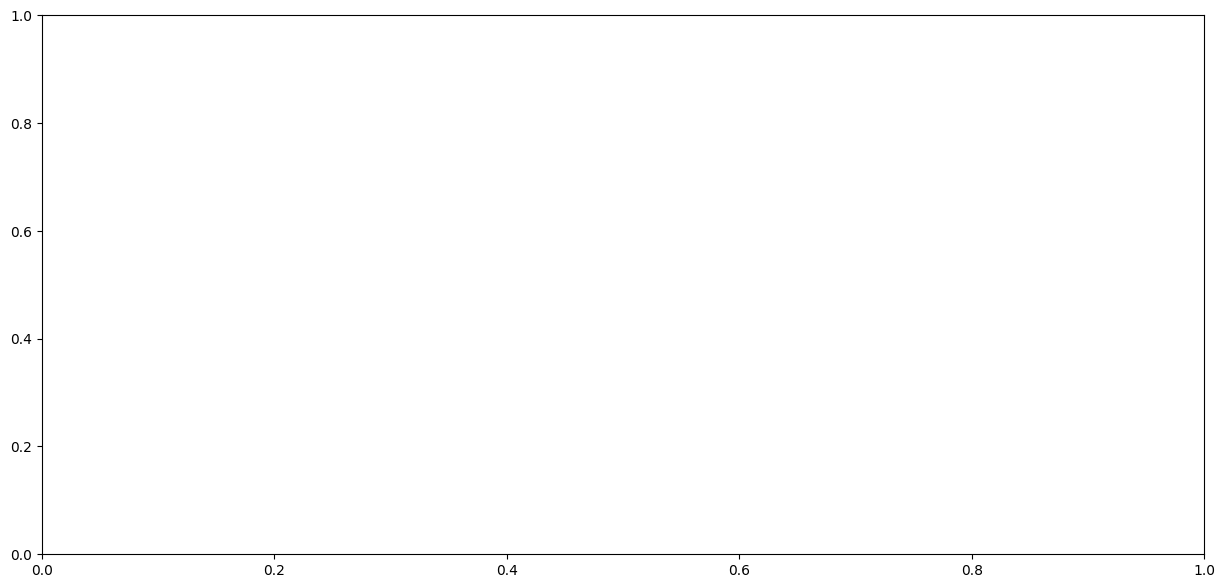

In [19]:
if run_config.loss == "daily_reward_lin_regr":
    fig_timestamps, ax_timestamps = plt.subplots(figsize=(15, 7))
    fig_timestamps, _ = plot_timestamps_left_per_class(fig_timestamps, ax_timestamps, stats, nclasses, class_names, mus, ylim=sequencelength, epoch=epoch)
    fig_timestamps.savefig(os.path.join(model_path, "timestamps_left_per_class.png"))
    print("fig saved at ", os.path.join(model_path, "timestamps_left_per_class.png"))
        
    fig_prob_class, axes_prob_class = plt.subplots(figsize=(15, 7*len(class_names)), nrows=len(class_names), sharex=True)
    fig_prob_class, _ = plot_fig_class_prob_wrt_time_with_mus(fig_prob_class, axes_prob_class, \
            stats["class_probabilities"], stats["targets"][:, 0], class_names, mus, config.p_thresh, \
            alpha=0.1, epoch=epoch)   
    fig_prob_class.savefig(os.path.join(model_path, "class_probabilities_wrt_time.png"))
    print("fig saved at ", os.path.join(model_path, "class_probabilities_wrt_time.png"))
     


In [26]:
for key, value in run.summary.items():
    print(f"{key}: {value}")

alphas: [0.7918367385864258, 0.12489796429872511, 0.08326529711484909]
conf_mat_table: {'ncols': 3, 'nrows': 81, 'sha256': '079042a735f09539175ea90f6e186347b78fb3f2421050c91ea962eb430690fb', 'artifact_path': 'wandb-client-artifact://ddoqy3mcpyf71uhmg7hk8wlqckzxu5489lg0zsijpb3ceimdonfjhg39kzv5vniidu5c0b61jb3d8m5ff7o840pidsfv708fnqub194jvgq08m8mib8pu2pc32zttpdc:latest/conf_mat_table.table.json', '_latest_artifact_path': 'wandb-client-artifact://ddoqy3mcpyf71uhmg7hk8wlqckzxu5489lg0zsijpb3ceimdonfjhg39kzv5vniidu5c0b61jb3d8m5ff7o840pidsfv708fnqub194jvgq08m8mib8pu2pc32zttpdc:latest/conf_mat_table.table.json', 'path': 'media/table/conf_mat_table_52_079042a735f09539175e.table.json', 'size': 2791, '_type': 'table-file'}
timestamps_left_plot: {'height': 700, 'sha256': 'eb7916cac0f6429c71f1dac375ffffeffcaecfcfd75e5259b724926f42d5a709', 'path': 'media/images/timestamps_left_plot_49_eb7916cac0f6429c71f1.png', 'size': 206108, '_type': 'image-file', 'width': 1500, 'format': 'png'}
loss: {'testloss': 